# Imports

In [1]:
# %% Imports
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.utilities.model_summary import summarize
import torch
import numpy as np
from datamodules import SimpleMicroDataModule, AlignedMicroDataModule
from models import CNNTransformer, Transformer, TCN_classifier, TemporalConvRNN
import augmentations as augs

import os
import sys
sys.path.append('..')
from alignment import alignment_utils as utils
from alignment.AlignCCA import AlignCCA

# Define data module

In [2]:
data_filename = os.path.expanduser('~/data/pt_decoding_data_S62.pkl')
# data_filename = ('../data/pt_decoding_data_S62.pkl')
pt_data = utils.load_pkl(data_filename)

In [3]:
pt = 'S14'
p_ind = -1
lab_type = 'phon'
algn_type = 'phon_seq'
tar_data, pre_data = utils.decoding_data_from_dict(pt_data, pt, p_ind,
                                                   lab_type=lab_type,
                                                   algn_type=algn_type)
print([d.shape for d in tar_data])
print([[d.shape for d in p] for p in pre_data])

[(432, 200, 111), (432,), (432, 3)]
[[(444, 200, 111), (444,), (444, 3)], [(453, 200, 63), (453,), (453, 3)], [(138, 200, 149), (138,), (138, 3)], [(453, 200, 74), (453,), (453, 3)], [(411, 200, 144), (411,), (411, 3)], [(423, 200, 171), (423,), (423, 3)], [(534, 200, 201), (534,), (534, 3)]]


In [4]:
fold_data_path = os.path.expanduser('~/workspace/transformer_data')
# fold_data_path = '.'

fs = 200 # Hz
augmentations = [augs.time_warping, augs.time_masking, augs.time_shifting, augs.noise_jitter, augs.scaling]
# augmentations = None
# data = torch.rand(n_samples, n_timepoints, n_features)
# labels = torch.randint(0, 9, (n_samples,))
# data = torch.Tensor(all_pt_dict['S14']['X1'])
# labels = torch.Tensor(all_pt_dict['S14']['y1']).long() - 1
data = torch.Tensor(tar_data[0])
labels = torch.Tensor(tar_data[1]).long() - 1
align_labels = torch.Tensor(tar_data[2]).long() - 1
pool_data = [(torch.Tensor(p[0]), torch.Tensor(p[1]).long() - 1, torch.Tensor(p[2]).long() - 1) for p in pre_data]
# data = torch.Tensor(all_pt_dict['S14']['X_collapsed'])
# labels = torch.Tensor(all_pt_dict['S14']['y_phon_collapsed']).long() - 1

# create the data module
batch_size = 5000
n_folds = 20
val_size = 0.1
dm = SimpleMicroDataModule(data, labels, batch_size=batch_size, folds=n_folds,
                           val_size=val_size, augmentations=augmentations, data_path=os.path.expanduser('~/workspace/transformer_data/pt_specific'))
# dm = AlignedMicroDataModule(data, labels, align_labels, pool_data, AlignCCA,
#                             batch_size=batch_size, folds=n_folds, val_size=val_size,
#                             augmentations=augmentations, data_path=fold_data_path)
# dm.setup()

# Define model

In [5]:
from pytorch_lightning.utilities.model_summary import summarize


gclip_val = 0.5

##### CNN TRANSFORMER #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# d_model = 128
# # d_model = data.shape[-1]
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# n_head = 8
# num_layers = 2
# dim_fc = 64
# # dim_fc = [128, 256, 128, 64]
# cnn_dropout = 0.3
# tform_dropout = 0.4
# learning_rate = 5e-4
# l2_reg = 1e-5
# gclip_val = 0.5
# activ = True

# sum_model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
#                            n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate)


##### Temporal CNN classifier #####

# # model parameters
# in_channels = data.shape[-1]
# num_classes = 9
# kernel_time = 50  # ms
# kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
# stride_time = 25  # ms
# stride = int(stride_time * fs / 1000)  # stride length in samples
# padding = 0
# dim_fc = [128, 256, 128, 64]
# cnn_dropout = 0.3
# learning_rate = 5e-4
# l2_reg = 1e-5
# gclip_val = 0.5
# activ = True

# sum_model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
#                            cnn_dropout, learning_rate, l2_reg)

##### Temporal CNN GRU #####

# model parameters
in_channels = data.shape[-1]
num_classes = 9
n_filters = 64
# d_model = data.shape[-1]
kernel_time = 50  # ms
kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
stride_time = 25  # ms
stride = int(stride_time * fs / 1000)  # stride length in samples
padding = 0
n_layers = 2
hidden_size = 500
dim_fc = [128, 64]
cnn_dropout = 0.3
rnn_dropout = 0.4
learning_rate = 1e-4
l2_reg = 1e-5
activ = False

sum_model = TemporalConvRNN(in_channels, n_filters, num_classes, hidden_size, n_layers,
                            kernel_size, dim_fc, stride, padding, cnn_dropout,
                            rnn_dropout, learning_rate, l2_reg)

print(summarize(sum_model))

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0      | train
1 | temporal_conv | TemporalConv     | 71.2 K | train
2 | rnn           | SimpleGRU        | 2.4 M  | train
3 | fc            | Sequential       | 8.8 K  | train
-----------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.985     Total estimated model params size (MB)


# Train model

In [6]:
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", "The number of training batches.*")

In [7]:
# instantiate the trainer
# max_epochs = 500
# es_pat = max_steps // 20
max_steps = 500
es_pat = 25
warmup = 50
# callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
log_dir = os.path.expanduser('~/workspace/transformer_data/transformer_logs')

In [8]:
# class MetricCollector(L.Callback):
#     def __init__(self):
#         self.metrics = {}
#     
#     def on_validation_epoch_end(self, trainer, pl_module):
#         self.metrics['val_loss'] = trainer.logger.metrics['val_loss']
#         self.metrics['val_acc'] = trainer.logger.metrics['val_acc']
#     
#     def on_test_epoch_end(self, trainer, pl_module):
#         self.metrics['test_loss'] = trainer.logger.metrics['test_loss']
#         self.metrics['test_acc'] = trainer.logger.metrics['test_acc']

In [9]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

def cmat_acc(y_hat, y, num_classes):
    y_pred = torch.argmax(y_hat, dim=1)
    cmat = multiclass_confusion_matrix(y_pred, y, num_classes)
    acc_cmat = cmat.diag().sum() / cmat.sum()
    return acc_cmat

In [10]:
# train the model
n_iters = 1
iter_accs = []
for i in range(n_iters):
    # dm.setup()
    
    fold_accs = []
    # y_pred_all = []
    # y_test_all = []
    for fold in range(n_folds):
        # if fold > 1:
        #     break
        dm.set_fold(fold)
        # print(dm.current_fold)
        
        # instantiate the model
        in_channels = dm.get_data_shape()[-1]
        # print(in_channels)
        # model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
        #                        n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate,
        #                        warmup, max_steps, l2_reg, activation=activ)
        # model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
        #                            cnn_dropout, learning_rate, l2_reg, activation=activ)
        model = TemporalConvRNN(in_channels, n_filters, num_classes, hidden_size, n_layers,
                                kernel_size, dim_fc, stride, padding, cnn_dropout,
                                rnn_dropout, learning_rate, l2_reg, activation=activ)
        
        # model.current_fold = fold
        callbacks = [
            ModelCheckpoint(monitor='val_loss'),
            EarlyStopping(monitor='val_loss', patience=es_pat),
            LearningRateMonitor(logging_interval='epoch'),
            ]
        trainer = L.Trainer(default_root_dir=log_dir,
                            # max_epochs=max_epochs,
                            max_steps=max_steps,
                            gradient_clip_val=gclip_val,
                            accelerator='auto',
                            callbacks=callbacks,
                            logger=True,
                            enable_model_summary=False,
                            enable_progress_bar=False,
                           )
        # # trainer.fit(model, dm)
        trainer.fit(model=model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())
        print(trainer.logged_metrics)
        # print the training metrics from the best model checkpoint
        # print(f'Fold {fold} best model metrics:')
        # print(trainer.checkpoint_callback.best_model_score)


        # trainer.test(model, dm)
        # model = CNNTransformer.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        trainer.test(model=model, dataloaders=dm.test_dataloader(), ckpt_path='best')
        # trainer.test(dataloaders=dm.test_dataloader(), ckpt_path='best')

        # test_pred = model(dm.test_dataloader().dataset.tensors[0])
        # test_pred = trainer.predict(model, dm.test_dataloader(), ckpt_path='best)[0]
        # test_pred = torch.argmax(test_pred, dim=1)
        # print(test_pred)
        # y_pred_all.extend(test_pred)
        # y_test_all.extend(dm.test_dataloader().dataset.tensors[1])
        
        fold_accs.append(trainer.logged_metrics['test_acc'])
    
        # save loss information
        # loss_dict = trainer.logger.metrics
        # loss_dict['fold'] = fold
        # loss_dict['model'] = model
    # acc = cmat_acc(torch.stack(y_pred_all), torch.stack(y_test_all), num_classes)
    # print(acc)
    # iter_accs.append(acc)
    # print(f'Averaged accuracy: {sum(fold_accs) / len(fold_accs)}')
    iter_accs.append(fold_accs)
    print(np.mean(fold_accs))
# print(sum(iter_accs) / len(iter_accs), iter_accs)
print(iter_accs)

/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/group/coganlab/zms14/miniconda3/envs/micro_deco ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/hpc/group/coganlab/zms14/miniconda3/envs/micro_decode/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` 

{'train_loss': tensor(1.5832), 'train_acc': tensor(0.4530), 'val_loss': tensor(2.3273), 'val_acc': tensor(0.1429)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss           2.1716644763946533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_896/checkpoints/epoch=18-step=19.ckpt


{'train_loss': tensor(1.1074), 'train_acc': tensor(0.6752), 'val_loss': tensor(2.8211), 'val_acc': tensor(0.0714)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_896/checkpoints/epoch=18-step=19.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
        test_loss           2.1569979190826416
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_897/checkpoints/epoch=30-step=31.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'train_loss': tensor(0.8133), 'train_acc': tensor(0.7795), 'val_loss': tensor(2.5713), 'val_acc': tensor(0.1429)}


Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_897/checkpoints/epoch=30-step=31.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.1517322063446045
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_898/checkpoints/epoch=32-step=33.ckpt


{'train_loss': tensor(0.7893), 'train_acc': tensor(0.7983), 'val_loss': tensor(2.5398), 'val_acc': tensor(0.0714)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_898/checkpoints/epoch=32-step=33.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4285714328289032
        test_loss           1.8368409872055054
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_899/checkpoints/epoch=18-step=19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_899/checkpoints/epoch=18-step=19.ckpt


{'train_loss': tensor(1.2651), 'train_acc': tensor(0.5949), 'val_loss': tensor(2.7203), 'val_acc': tensor(0.0714)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss           2.1988027095794678
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_900/checkpoints/epoch=26-step=27.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_900/checkpoints/epoch=26-step=27.ckpt


{'train_loss': tensor(1.0213), 'train_acc': tensor(0.6735), 'val_loss': tensor(2.8595), 'val_acc': tensor(0.)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss           2.1461732387542725
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_901/checkpoints/epoch=25-step=26.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_901/checkpoints/epoch=25-step=26.ckpt


{'train_loss': tensor(0.9830), 'train_acc': tensor(0.7368), 'val_loss': tensor(2.7652), 'val_acc': tensor(0.1429)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss            2.091010093688965
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_902/checkpoints/epoch=27-step=28.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_902/checkpoints/epoch=27-step=28.ckpt


{'train_loss': tensor(0.9794), 'train_acc': tensor(0.6940), 'val_loss': tensor(2.7733), 'val_acc': tensor(0.0714)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss            2.188490390777588
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_903/checkpoints/epoch=27-step=28.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_903/checkpoints/epoch=27-step=28.ckpt


{'train_loss': tensor(0.9549), 'train_acc': tensor(0.6872), 'val_loss': tensor(2.6095), 'val_acc': tensor(0.4286)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
        test_loss            2.383089542388916
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_904/checkpoints/epoch=23-step=24.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_904/checkpoints/epoch=23-step=24.ckpt


{'train_loss': tensor(0.9618), 'train_acc': tensor(0.7214), 'val_loss': tensor(3.3100), 'val_acc': tensor(0.2143)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
        test_loss            2.198420286178589
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_905/checkpoints/epoch=31-step=32.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_905/checkpoints/epoch=31-step=32.ckpt


{'train_loss': tensor(0.7174), 'train_acc': tensor(0.8308), 'val_loss': tensor(2.4579), 'val_acc': tensor(0.2143)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
        test_loss           2.4639437198638916
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_906/checkpoints/epoch=35-step=36.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_906/checkpoints/epoch=35-step=36.ckpt


{'train_loss': tensor(0.9063), 'train_acc': tensor(0.7282), 'val_loss': tensor(2.9684), 'val_acc': tensor(0.2143)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss            2.074599504470825
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_907/checkpoints/epoch=23-step=24.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_907/checkpoints/epoch=23-step=24.ckpt


{'train_loss': tensor(1.1288), 'train_acc': tensor(0.6256), 'val_loss': tensor(2.9846), 'val_acc': tensor(0.0714)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1428571492433548
        test_loss           2.0509462356567383
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_908/checkpoints/epoch=22-step=23.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_908/checkpoints/epoch=22-step=23.ckpt


{'train_loss': tensor(1.0870), 'train_acc': tensor(0.6479), 'val_loss': tensor(2.4565), 'val_acc': tensor(0.2143)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
        test_loss            2.288362741470337
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_909/checkpoints/epoch=5-step=6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'train_loss': tensor(1.6679), 'train_acc': tensor(0.5162), 'val_loss': tensor(2.3952), 'val_acc': tensor(0.1429)}


Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_909/checkpoints/epoch=5-step=6.ckpt


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
        test_loss           2.2337543964385986
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_910/checkpoints/epoch=25-step=26.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_910/checkpoints/epoch=25-step=26.ckpt


{'train_loss': tensor(1.0528), 'train_acc': tensor(0.6769), 'val_loss': tensor(2.3488), 'val_acc': tensor(0.2143)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.0320003032684326
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_911/checkpoints/epoch=23-step=24.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_911/checkpoints/epoch=23-step=24.ckpt


{'train_loss': tensor(0.9860), 'train_acc': tensor(0.6974), 'val_loss': tensor(2.8426), 'val_acc': tensor(0.2143)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
        test_loss            2.38401460647583
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_912/checkpoints/epoch=30-step=31.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_912/checkpoints/epoch=30-step=31.ckpt


{'train_loss': tensor(0.7456), 'train_acc': tensor(0.8171), 'val_loss': tensor(2.7798), 'val_acc': tensor(0.1429)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2857142984867096
        test_loss           2.1311023235321045
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_913/checkpoints/epoch=36-step=37.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_913/checkpoints/epoch=36-step=37.ckpt


{'train_loss': tensor(0.6151), 'train_acc': tensor(0.8254), 'val_loss': tensor(2.5884), 'val_acc': tensor(0.2857)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3333333432674408
        test_loss            2.151750326156616
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restoring states from the checkpoint path at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_914/checkpoints/epoch=19-step=20.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/zms14/workspace/transformer_data/transformer_logs/lightning_logs/version_914/checkpoints/epoch=19-step=20.ckpt


{'train_loss': tensor(1.1455), 'train_acc': tensor(0.6729), 'val_loss': tensor(2.4664), 'val_acc': tensor(0.2143)}
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1666666716337204
        test_loss           2.1904489994049072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
0.13928571
[[tensor(0.1429), tensor(0.), tensor(0.2857), tensor(0.4286), tensor(0.1429), tensor(0.1429), tensor(0.1429), tensor(0.1429), tensor(0.), tensor(0.), tensor(0.), tensor(0.1429), tensor(0.1429), tensor(0.), tensor(0.), tensor(0.2857), tensor(0.), tensor(0.2857), tensor(0.3333), tensor(0.1667)]]


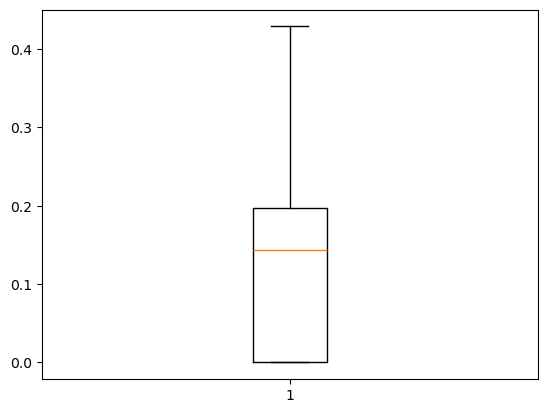

In [11]:
import matplotlib.pyplot as plt
from torch import tensor
# test = [[tensor(0.5000), tensor(0.3636), tensor(0.2727), tensor(0.4545), tensor(0.3182), tensor(0.4545), tensor(0.4091), tensor(0.2273), tensor(0.2727), tensor(0.4091), tensor(0.2727), tensor(0.3182), tensor(0.3333), tensor(0.3333), tensor(0.4762), tensor(0.3333), tensor(0.2857), tensor(0.3810), tensor(0.3810), tensor(0.3810)]]
plt.boxplot(fold_accs)
plt.show()

In [14]:

np.mean(fold_accs)

0.20790043